# Tutorial: Dispatcher

This notebook demonstrates how to use dispatcher.

In [34]:
import numpy as np
import yaml
from flumodelingsuite.config_loader import load_basemodel_config_from_file, load_sampling_config_from_file, load_calibration_config_from_file, load_output_config_from_file
from flumodelingsuite.schema.general import validate_modelset_consistency

In [35]:
from flumodelingsuite.dispatcher import (
    dispatch_builder,
    dispatch_runner,
    dispatch_output_generator,
)

In [36]:
from epydemix.visualization import plot_quantiles
from matplotlib import pyplot as plt

In [37]:
# import logging
# import sys

# root = logging.getLogger()
# if root.handlers:
#     root.handlers.clear()

# logging.basicConfig(
#     level=logging.INFO,
#     stream=sys.stdout,
#     format="%(asctime)s %(name)s %(levelname)s: %(message)s",
# )

***
## Loading configs

In [38]:
basemodel_config_sampling = load_basemodel_config_from_file("data/flu_round05_basemodel_sampling.yml")
basemodel_config_calibration = load_basemodel_config_from_file("data/flu_round05_basemodel_calibration.yml")

In [39]:
basemodel_config_standalone = load_basemodel_config_from_file("data/basic_basemodel_standalone.yml")

In [40]:
sampling_config = load_sampling_config_from_file("data/flu_round05_modelset_sampling.yml")

In [41]:
calibration_config = load_calibration_config_from_file("data/flu_round05_modelset_calibration.yml")
output_config = load_output_config_from_file("data/basic_output.yaml")

In [57]:
# Override calibration settings temporarily
calibration_config.modelset.calibration.strategy.options['num_generations'] = 7

***
## Validate config consistency

In [58]:
validate_modelset_consistency(basemodel_config_sampling, sampling_config)

In [59]:
validate_modelset_consistency(basemodel_config_calibration, calibration_config)

***
## Dispatcher - Builder

In [60]:
builder_output_sampling = dispatch_builder(basemodel_config=basemodel_config_sampling, sampling_config=sampling_config)

In [61]:
builder_output_calibration = dispatch_builder(basemodel_config=basemodel_config_calibration, calibration_config=calibration_config)

In [62]:
builder_output_standalone = dispatch_builder(basemodel_config=basemodel_config_standalone)

***
## Dispatcher - Runner

In [63]:
runnder_output_sampling = dispatch_runner(builder_output_sampling[0])

In [64]:
# runnder_output_sampling.results

In [65]:
runner_output_calibration = dispatch_runner(builder_output_calibration[0])

Starting ABC-SMC with 20 particles and 7 generations

Generation 1/7 (epsilon: inf)
	Accepted 20/20 (acceptance rate: 100.00%)
	Elapsed time: 00:00:08

Generation 2/7 (epsilon: 856.036866)
	Accepted 20/34 (acceptance rate: 58.82%)
	Elapsed time: 00:00:14

Generation 3/7 (epsilon: 599.893793)
	Accepted 20/51 (acceptance rate: 39.22%)
	Elapsed time: 00:00:22

Generation 4/7 (epsilon: 409.232720)
	Accepted 20/104 (acceptance rate: 19.23%)
	Elapsed time: 00:00:44

Generation 5/7 (epsilon: 270.166464)
	Accepted 20/105 (acceptance rate: 19.05%)
	Elapsed time: 00:00:44

Generation 6/7 (epsilon: 214.164481)
	Accepted 20/212 (acceptance rate: 9.43%)
	Elapsed time: 00:01:29

Generation 7/7 (epsilon: 149.813526)
	Accepted 20/399 (acceptance rate: 5.01%)
	Elapsed time: 00:02:46


In [66]:
# runner_output_calibration.results

In [67]:
runner_output_standalone = dispatch_runner(builder_output_standalone)

***
## Dispatcher - Output Generator

In [68]:
# Generate outputs for calibration projection results
output_files = dispatch_output_generator(calibrations=[runner_output_calibration], output_config=output_config)

In [69]:
# # Save the generated outputs to disk
# import os
# output_dir = "output"
# os.makedirs(output_dir, exist_ok=True)

# print(f"Generated {len(output_files)} output files:")
# for filename, gzipped_data in output_files.items():
#     filepath = os.path.join(output_dir, filename)
#     with open(filepath, "wb") as f:
#         f.write(gzipped_data)
#     print(f"  - Saved: {filepath} ({len(gzipped_data)} bytes)")

## Plotting

In [70]:
calibration_quantiles = runner_output_calibration.results.get_calibration_quantiles()

In [71]:
projection_quantiles = runner_output_calibration.results.get_projection_quantiles()

In [72]:
# Sum up transitions
projection_quantiles['data'] = np.sum(projection_quantiles[['Home_sev_to_Hosp_total', 'Home_sev_vax_to_Hosp_vax_total']], axis=1)

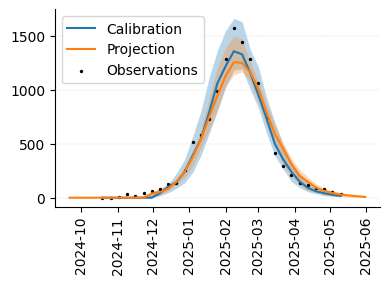

In [73]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

# ax.scatter(x, y, marker='o', lw=0)
plot_quantiles(
    calibration_quantiles,
    ax=ax,
    labels="Calibration",
    columns=["data"],
    colors="C0",
)

plot_quantiles(
    projection_quantiles,
    ax=ax,
    labels="Projection",
    columns=["data"],
    colors="C1",
)

ax.scatter(
    calibration_quantiles['date'].unique(),
    runner_output_calibration.results.observed_data['data'],
    color='black',
    label='Observations',
    s=2
)

ax.set_title("", loc='left')

ax.set_xlabel("")
ax.set_ylabel("")

ax.tick_params(axis='x', labelrotation=90)

ax.legend(loc='upper left', frameon=True)

fig.tight_layout()
plt.show()